# 3 | Linear Neural Networks 

In [1]:
import numpy as np
from numpy import ndarray
from typing import Dict, Tuple, List
import matplotlib.pyplot as plt

In [2]:
def analytic_solution(X: ndarray, y: ndarray) -> ndarray:
    return np.linalg.inv(np.dot(X.T,X)).dot(X.T).dot(y)

In [3]:
X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100,1)

X_b = np.c_[np.ones((100,1)), X]

NameError: name 'predicted_params' is not defined

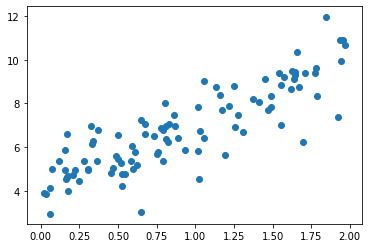

In [4]:
plt.scatter(X, y)
plt.plot(X, (predicted_params[0] + predicted_params[1] * X))
plt.plot(X, (4 + 3 * X))
plt.legend(['predicted_vals', 'true_value'])

In [ ]:
predicted_params = analytic_solution(X_b, y)

In [ ]:
preds = predicted_params[0] + predicted_params[1] * X + np.random.rand(100,1)

Since we will benchmark the running time frequently in this book, let's define a timer to track the running time.

In [5]:
%matplotlib inline
import d2l
import math
from mxnet import np, npx, autograd
import time
import random

npx.set_np()

In [6]:
n = 10000
a = np.ones(n)
b = np.ones(n)

In [7]:
class Timer(object):
    def __init__(self):
        self.times = []
        self.start()
        
    def start(self):
        self.tik = time.time()
    
    def stop(self):
        self.times.append(time.time() - self.tik)
        return self.times[-1]
    
    def avg(self):
        return sum(self.times) / len(self.times)
    
    def sum(self):
        return sum(self.times)
    
    def cumsum(self):
        # Return the accumulated times
        return np.array(self.times).cumsum().tolist()

In [8]:
c = np.zeros(n)
timer = Timer()

for i in range(n):
    c[i] = a[i] + b[i] # a normal for loop
'%.5f sec' % timer.stop()

'4.02294 sec'

In [9]:
timer.start()
d = a + b # vectorized operation
'%.5f sec' % timer.stop()

'0.00052 sec'

#### 3.1.2 The Normal Distribution and Squared Loss

In [10]:
def normal(z, mu, sigma):
    p = 1 / math.sqrt(2 * math.pi * sigma ** 2)
    return p * np.exp(-0.5 / sigma ** 2 * (z - mu) ** 2)

# def norm_my(z, mu, sigma):
#     return 1 / np.sqrt(2 * math.pi * sigma ** 2) * np.exp(-(1/2) / sigma ** 2 * (z - mu) ** 2)

Let's visualize this

In [11]:
x = np.arange(-7, 7, 0.01)

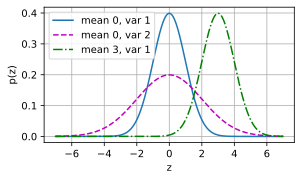

In [12]:
parameters = [(0, 1), (0, 2), (3, 1)]

d2l.plot(x, [normal(x,mu,sigma) for mu,sigma in parameters], xlabel = 'z',
        ylabel = 'p(z)', figsize=(4.5, 2.5), legend = ['mean %d, var %d' % (mu, sigma) for mu, sigma in parameters])

## Linear Regression Implementation from Scratch

#### 3.2.1 Generating the Dataset

To keep things simple, we will construct an artificial dataset according to a linear model with additive noise. Our task will be to recover this model's parameters using the finite set of examples contained in our dataset. We will keep the data low-dimensional so we can visualize it easily. Our dataset consists of 1000 examples, each with 2 features sampled from a standard normal distribution.

The true parameters generating our data will be $w = [2, -3.4]^T$ and $b = 4.2$ and our synthetic labels will be assigned according to the following linear model with noise term $\epsilon$. So, this gives us:

$y = Xw + b + \epsilon$

You could think of $\epsilon$ as capturing potential measurement errors on the features and labels. We will assume that the standard assumptions hold and thus that $\epsilon$ obeys a normal distribution with mean of 0. To make our problem easy, we will set its standard deviation to 0.01

In [13]:
def synthetic_data(w, b, num_examples):
    """Generate y = Xw + b + noise"""
    X = np.random.normal(0,1, (num_examples, len(w)))
    y = np.dot(X, w) + b
    y += np.random.normal(0, 0.01, y.shape)
    
    return X,y 

In [14]:
true_w = np.array([2, -3.4])
true_b = 4.2

features, labels = synthetic_data(true_w, true_b, 1000)

In [15]:
print(f"Features: {features[0]}, \nLabel: {labels[0]}")

Features: [1.1630787 2.2122064], 
Label: -1.0015326


By generating a scatter plot using the second column of features (features[:, 1]) and labels, we can clearly observe the linear correlation between the two.

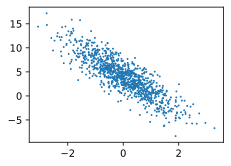

In [16]:
d2l.set_figsize((3.5, 2.5))
d2l.plt.scatter(features[:, 1].asnumpy(), labels.asnumpy(), 1)

#### 3.2.2 Reading the Dataset

Recall that training models consists of making **multiple passes over the dataset, grabbing one minibatch of examples at a time, and using them to update our model.** Since this process is so fundamental to training machine learning algorithms, its worth defining a utility function to shuffle the data and access it in minibatches.

In [17]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # The examples are read at random, in no particular order
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = np.array(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices] 

In [34]:
batch_size = 10

for X,y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

[[-0.80917114 -0.05834173]
 [-0.7517      0.02384045]
 [-1.0410905   0.46068263]
 [ 0.16916618 -0.55512375]
 [ 0.92333424  0.23408559]
 [-0.18903568  1.0043472 ]
 [ 0.77062917 -0.27214044]
 [ 0.70102096  1.5069913 ]
 [ 1.2546344  -1.9768796 ]
 [ 2.1780314  -0.10548475]] 
 [ 2.7689087   2.603815    0.55753493  6.4290004   5.2316155   0.40822986
  6.6641726   0.4765883  13.437693    8.914491  ]


As we run the iterator, we obtain distinct minibatches succcessively until all the data has been exhausted. While the iterator implemented above is good for a simple example that does not contain many data points, it is inefficient in many ways that might get us in trouble on real problems. For example, it requires that we load all data in memory and that we perform lots o random memory access.

#### 3.2.3 Initializing Model Parameters

Before we can begin optimizing our model's parameters by gradient descent, we need to have some parameters in the first place. In the following code, we initialize weights by sampling random numbers from a normal distribution with mean 0 and std. dev 0.01, setting the bias to 0.

In [19]:
w = np.random.normal(0, 0.01, (2,1))
b = np.zeros(1)

Now that we have initialized our parameters, our next task is to update them until they fit our data sufficiently well. Each update requires taking the gradient (a multi-dimensional derivative) of our loss function with respect to the parameters. Given this gradient, we can update each parameter in the direction that reduces the loss.

Since computing gradients explicitly ("by hand") is tedious and error prone, we use automatic differentiation to compute the gradient. Recall from the chapter on autograd that in order for `autograd` to know that it should store a gradient for our parameters, we need to invoke the `attach_grad()` function, allocating memory to store the gradients that we plan to take.

In [20]:
w.attach_grad()
b.attach_grad()

#### 3.2.4 Defining the Model

Next, we must define our model, relating its inputs and parameters to its outputs. To calculate the output of the linear model, we simply take the matrix-vector dot product of the examples $X$ and the model weights $w$, and add the offset $b$ to each example. Note that below np.dot(X,w) is a vector and b is a scalar. Recall that when we add a vector and a scalar, the scalar is **added to each component of the vector**

In [21]:
def linreg(X, w, b):
    return np.dot(X,w) + b

#### 3.2.5 Defining the Loss Function

Since updating our model requires taking the gradient of our loss function, we ought to define the loss function first. Here we will use the squared loss function as described in the previous section. In the implementation, we need to transform the true value $y$ into the predicted value's shape $\hat{y}$. The result returned by the following function will also be the same as the $\hat{y}$ shape.

In [22]:
def squared_loss(y_hat, y):
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

#### 3.2.6 Defining the Optimization Algorithm

At each step, using one batch randomly drawn from our dataset, we will estimate the gradient of the loss with respect to our parameters. Next, we will update our parameters (a small amount) in the direction that reduces the loss. Recall that after we call `backward` each parameter (`param`) will have its gradient stored in `param.grad`. The following code applies the SGD update, given a set of parameters, a learning rate, and a batch size. The size of the update step is determined by the learning rate `lr`. **Because our loss is calculated as a sum over the batch of examples, we normalize our step size by the batch size, so that the magnitude of a typical step size does not depend heavily on our choice of the batch size.**

In [23]:
def sgd(params, lr, batch_size):
    for param in params:
        param[:] = param - lr * param.grad / batch_size

#### 3.2.7 Training 

Now that we have all of the parts in place, we are ready to implement the main training loop. It is crucial to understand the following code, because the loops used to perform training are almost always identical and you will see them throughout your career in deep learning.

In each iteration, we will grab minibatches of examples, first passing them through our model to obtain a set of predictions. After calculating the loss, we call the `backward` function to initiate the backwards pass through the network, storing the gradients with respect to each parameter in its corresponding `.grad` attribute. Finally, we will call the optimization algorithm `sgd` to update the model parameters. Since we previously set the `batch_size` to 10, the loss shape 1 for each minibatch is $(10,1)$.

In summary, we will execute the following loop:

- Initialize parameters $(w,b)$
- Repeat until done:
    - Compute gradient $g$
    - Update parameters $(w,b)$
    
    
In the code below, `l` is a vector of losses for each example in the minibatch. Because `l` is not a scalar variable, running `l.backward()` adds together the elements in `l` to obtain a new variable and then calculates the gradient.

In each epoch (a pass through the data), we will iterate through the entire dataset (using the `data_iter` function) once passing through every examples in the training dataset (assuming the number of examples is divisible by the batch_size). The number of epochs `num_epochs` and the learning rate are both hyper-parameters, which we set here to 3 and 0.03, respectively. Unfortunately, setting hyper-parameters is tricky and requires some adjustment by trial and error.

In [24]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss


for epoch in range(num_epochs):
    # Assuming the number of examples can be divided by the batch_size, all
    # the examples in the training dataset are used once in one epoch
    # iteration. The features and labels of minibatch examples are given by X
    # and y respectively.
    for X, y in data_iter(batch_size, features, labels):
        with autograd.record():
            l = loss(net(X, w, b), y) # Minibatch loss in X and y
        l.backward() # Compute gradient on l with respect to [w,b]
        sgd([w, b], lr, batch_size) # Update parameters using their gradient
    train_l = loss(net(features, w, b), labels)
    print(f"epoch: {epoch + 1}, loss: {train_l.mean().asnumpy()}")

epoch: 1, loss: 0.050418686121702194
epoch: 2, loss: 0.0002093663060804829
epoch: 3, loss: 5.174890247872099e-05


In this case, because we synthesized the data ourselves, we know precisely what the true parameters are. Thus, we can evaluate our success in training by comparing the true parameters with those that we learned through our training loop. Indeed they turn out to be very close to each other.

In [38]:
print('Error in estimating w', true_w - w.reshape(true_w.shape))
print('Error in estimating b', true_b - b)

Error in estimating w [ 0.0006628  -0.00036716]
Error in estimating b [0.00136089]


In [51]:
print(f"True value of parameters: {true_w}")
print(f"Estimated value of parameters: {w}")

True value of parameters: [ 2.  -3.4]
Estimated value of parameters: [[ 1.9993372]
 [-3.399633 ]]


Note that we should not take it for granted that we are able to recover the parameters accurately. This only happens for a special category problems: strongly convex optimization problems with "enough" data to ensure that the noisy samples allow us to recover the underlying dependency. In most cases that is *not* the case. In fact, the parameters of a deep network are rarely the same (or even close) between two different runs, unless all conditions are identical, including the order in which the data is traversed. However, in ML, we are typically less concerned with recovering the true underlying parameters (a process known as *inference*), and more concerned with the parameters that lead to **accurate prediction**. Fortunately, even on difficult optimization problems, stochastic gradient descent can often find remarkably good solutions, owing partly to the fact, **for deep networks, there exist many configurations of parameters that lead to accurate prediction.**

## 3.3 Concise Implementation of Linear Regression

Implementing the algorithms from scratch is a good technique to fully grasp the concepts and mechanics of algos. However, because so many elements occurring in DL are used in almost every situation (optimizers, loss functions, models, NN layers), modern DL libraries implement all those components. This part will go over the same example, but in a much succinct form.

In [52]:
import d2l
from mxnet import autograd, gluon, np, npx
npx.set_np()

In [53]:
true_w = np.array([2., -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

#### 3.3.2 Reading the Dataset

Rather than rolling our own iterator, we can call upon Gluon's data module to read data. The first step will be to instantiate *ArrayDataset*. This object's constructor takes one or more ndarrays as arguments. Here, we pass in features and labels as arguments. Next, we will use the ArrayDataset to instantiate a DataLoader, which also requires that we specify a `batch_size` and specify a Boolean value `shuffle` indicating whether or not we want the DataLoader to shuffle the data on each epoch (pass through the dataset).

In [80]:
def load_array(data_arrays, batch_size, is_train = True):
    """Construct a Gluon data loader"""
    dataset = gluon.data.ArrayDataset(*data_arrays) # Tuple unpacking :)
    return gluon.data.DataLoader(dataset, batch_size, shuffle=is_train)

In [55]:
batch_size = 10
data_iter = load_array((features, labels), batch_size)

In [71]:
# Checking that everything is working properly
for X, y in data_iter:
    print(X, '\n', y)
    break

[[ 0.16353653 -0.3187339 ]
 [ 1.3687577   1.4016091 ]
 [ 0.35921553 -1.628112  ]
 [ 0.91621286  1.4198927 ]
 [-0.2626254  -0.4579232 ]
 [ 1.6341009  -1.5383639 ]
 [ 0.3818393   0.8296984 ]
 [-0.22812165 -0.6634837 ]
 [ 1.8286113  -0.16813755]
 [ 0.6871126   0.6407658 ]] 
 [ 5.6261053  2.1771529 10.459195   1.2029194  5.226611  12.693607
  2.1377728  6.0020094  8.4196415  3.406622 ]


#### 3.3.3 Defining the Model

When we implemented the Linear Regression from scratch, we defined our model parameters explicitly and coded up the calculations to produce output using basic linear algebra operations. But once the models get more complex, and once you have to do this nearly every day, you'll be glad for the assistance. The situation is similar to coding up your own blog from scratch. Doing it once or twice is rewarding and instructive, but you would be a lousy web dev if every time you needed a blog you spent a month reinventing the wheel.

For standard operations, we can use Gluon's predefined layers, which allow us to focus especially on the layers used to construct the model rather than having to focus on the implementation. To define a linear model, we first import the `nn` module, which defines a large number of neural network layers. We will first define a model variable `net`, which will refer to an instance of the *Sequential* class. In Gluon, Sequential defines a container for several layers that will be **chained together**. Given input data, a Sequential passes it through the first layer, in turn passing the output as the second layer's input and so forth. In the following example, our model consists of only one layer, so we do not really need the Sequential class to do this. But since nearly all of our future models will involve multiple layers, we will use it anyway just to familiarize you with the most standard workflow.

In [72]:
from mxnet.gluon import nn
net = nn.Sequential()

Recall the architecture of a single-layer network. The layer is said to be *fully-connected* because **each of its inputs are connected to each of its outputs by means of matrix-vector multiplication**. In Gluon, the fully-connected layer is defined in the `Dense` class. Since we only want to generate a single scalar output, we set that number to 1.

In [73]:
net.add(nn.Dense(1))

It is worth noting that, for convenience, Gluon does not require us to specify the input shape for each layer. So here, we do not need to tell Gluon how many inputs go into this linear layer. When we first try to pass data through our model, e.g. when we execute `net(X)` later, Gluon will automatically infer the number of inputs to each layer.

#### 3.3.4 Initializing Model Parameters

Before using net, we need to initialize the model parameters, such as the weights and biases in the linear regression model. We will import the `initializer` module from MXNet. This module provides various methods for model parameter initalization. Gluon makes `init` available as a a shortcut (abbrev.) to access the initializer package. By calling init.Normal(sigma = 0.01), we specify that each weight parameter should be randomly sampled from a normal distribution with mean 0 and standard dev. 0.01. The bias parameter will be initialized to zero by default. Both the weight vector and bias will have attached gradients.

In [75]:
from mxnet import init
net.initialize(init.Normal(sigma = 0.01))

**Important note here**. The code above may look straightforward to you, but you should note that something strange is happening here. We are initializing parameters for a network even though Gluon does not yet know the dimensionality of our input data! It might be 2 as in our example or it might be 2000. Gluon lets us get away with this because behind the scenes, the initialization is actually *deferred*. The real initialization will take place only when we for the first time attempt to pass data through the network. Just be careful to remember that since the parameters have not been initialized yet, we cannot access or manipulate them.

#### 3.3.5 Defining the Loss Function

In Gluon, the loss module defines various loss functions. We will use the imported module loss with the pseudonym `gloss`, to avoid confusing it for the variable holding our chosen loss function. In this example, we will use the Gluon implementation of squared loss (L2Loss).

In [76]:
from mxnet.gluon import loss as gloss

In [77]:
loss = gloss.L2Loss()

#### 3.3.6 Defining the Optimization Algorithm

Minibatch SGD and related variants are standard tools for optimizing neural networks and thus Gluon supports SGD alongside a number of variations on this algorithm through its `Trainer` class. When we instantiate the Trainer, we will specify the parameters to optimize over (obtainable from our net via `net.collect_params()`), the optimization algorithm we wish to use (sgd), and a dictionary of hyper-parameters required by our optimization algorithm. SGD just requires that we set the value learning_rate (here, we set it to 0.03).

In [78]:
from mxnet import gluon

In [79]:
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.03})

#### 3.3.7 Training

The process is exactly the same as before: for some number of epochs, we will make a complete pass over the dataset (train_data), iteratively grabbing one minibatch of inputs and the corresponding ground-truth labels. For each minibatch, we go through the following ritual:

- Generate predictions by calling `net(X)` and calculate the loss `l` (the forward pass)

- Calculate the gradients by calling `l.backward()`

- Update the model parameters by invoking our SGD optimizer (note that `trainer` already knows which parameters to optimize over, so we just need to pass in the minibatch size.

In [83]:
num_epochs = 3

for epoch in range(1, num_epochs + 1):
    for X, y in data_iter:
        with autograd.record():
            l = loss(net(X), y)
        l.backward()
        trainer.step(batch_size)
    l = loss(net(features), labels)
    print(f"Epoch: {epoch}, Loss: {l.mean().asnumpy()}")

Epoch: 1, Loss: 0.03535105660557747
Epoch: 2, Loss: 0.00012355715443845838
Epoch: 3, Loss: 4.931864532409236e-05


Below, we compare the model parameters learned by training on finite data and the actual parameters that generated out dataset. To access parameters with Gluon, we first access the layer that we need from net and then access that layer's weight and bias. To access each parameter's values as an ndarray, we invoke its data method. As in our from-scratch implementation, note that our estimated parameters are close to their ground truth counterparts.

In [86]:
w = net[0].weight.data()
print('Estimated w\'s:', w)
b = net[0].bias.data()
print('Estimated b:', b)
print('\n')
print(f"True value of w: {true_w}")
print(f"True value of b: {true_b}")

Estimated w's: [[ 2.0001094 -3.399599 ]]
Estimated b: [4.1993523]


True value of w: [ 2.  -3.4]
True value of b: 4.2
